# Project Description

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

**As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.**

In this notebook, I do refer to an existing work of [EKREM BAYAR](https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing/notebook)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, shapiro, mannwhitneyu
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
Image(url= "https://tactilegames.com/wp-content/uploads/2018/05/cookie-cats.png", width=600, height=600)

## 1. Feature Engineering

In [3]:
df = pd.read_csv('cookie_cats.csv')

In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df['retention_1'] = df['retention_1'].apply(lambda x: 1 if x == True else 0)

In [6]:
df['retention_7'] = df['retention_7'].apply(lambda x: 1 if x == True else 0)

In [7]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [8]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,90189.0000,90189.0000,90189.0000,90189.0000
mean,4998412.2345,51.8725,0.4452,0.1861
std,2883285.6077,195.0509,0.4970,0.3892
min,116.0000,0.0000,0.0000,0.0000
25%,2512230.0000,5.0000,0.0000,0.0000
50%,4995815.0000,16.0000,0.0000,0.0000
75%,7496452.0000,51.0000,1.0000,0.0000
max,9999861.0000,49854.0000,1.0000,1.0000


The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

* userid - a unique number that identifies each player.
* version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
* sum_gamerounds - the number of game rounds played by the player during the first week after installation
* retention_1 - did the player come back and play 1 day after installing?
* retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

*From the description, it has shown that around 44% of players come back after 1 day the feature was released. However, the ratio dropped down to 18% after 7 days.*

In [9]:
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].transpose()

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


We can see that there are extreme values in the dataset. We want to exclude them out before any further calculation

In [10]:
df.groupby('version').describe()['sum_gamerounds']

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0000,52.4563,256.7164,0.0000,5.0000,17.0000,50.0000,49854.0000
gate_40,45489.0000,51.2988,103.2944,0.0000,5.0000,16.0000,52.0000,2640.0000


In [11]:
# Number of extreme sum_gamerounds which is greater than the max of the treatment group
df.query('sum_gamerounds > 2640').count()

userid            2
version           2
sum_gamerounds    2
retention_1       2
retention_7       2
dtype: int64

In [12]:
# Number of users downloaded the game but never play it
df.query('sum_gamerounds == 0').count()

userid            3994
version           3994
sum_gamerounds    3994
retention_1       3994
retention_7       3994
dtype: int64

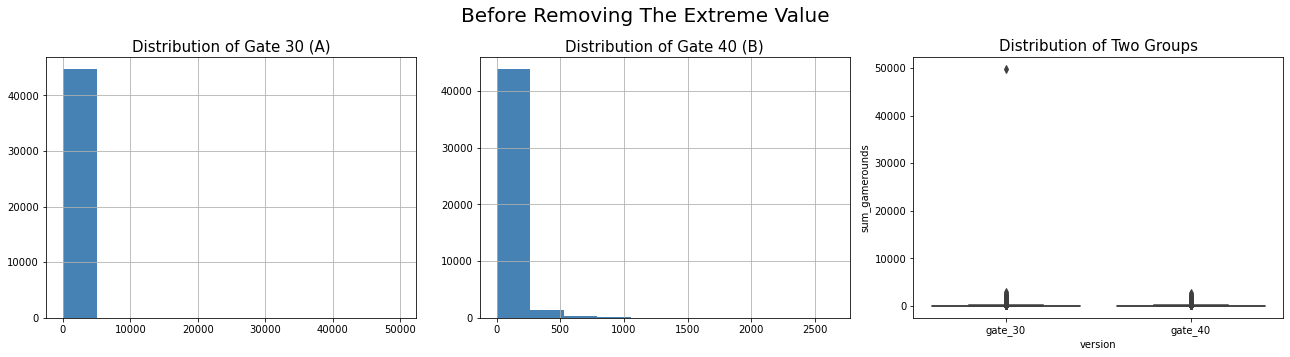

In [13]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))

df.query('version == "gate_30"').hist("sum_gamerounds", ax = axes[0], color = "steelblue")
df.query('version == "gate_40"').hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x ='version', y = 'sum_gamerounds', data=df, ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 1);
plt.savefig('Before Removing The Extreme Value.png')

We will treat outliers by removing all sum_gamerounds value > 2640 and sum_gamerounds value == 0

In [14]:
df = df.query('sum_gamerounds > 0 and sum_gamerounds <= 2640')

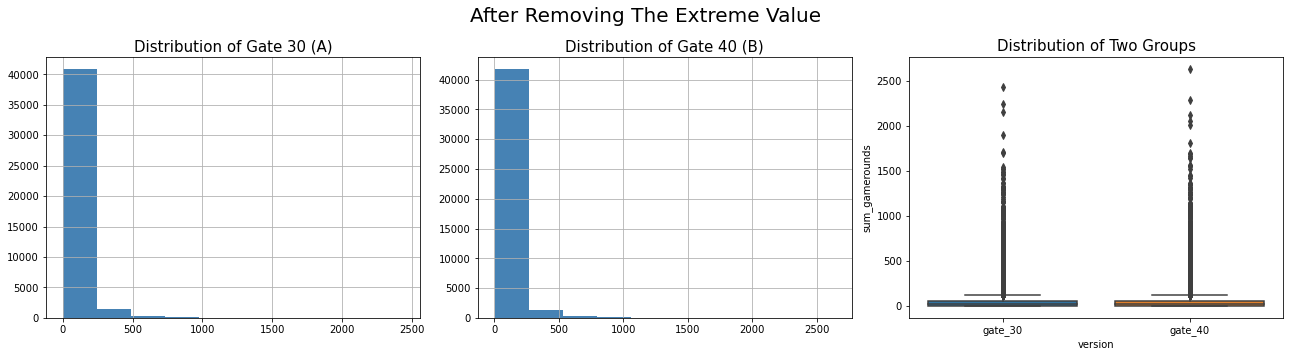

In [15]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))

df.query('version == "gate_30"').hist("sum_gamerounds", ax = axes[0], color = "steelblue")
df.query('version == "gate_40"').hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x ='version', y = 'sum_gamerounds', data=df, ax = axes[2])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 1);
plt.savefig('After Removing The Extreme Value.png')

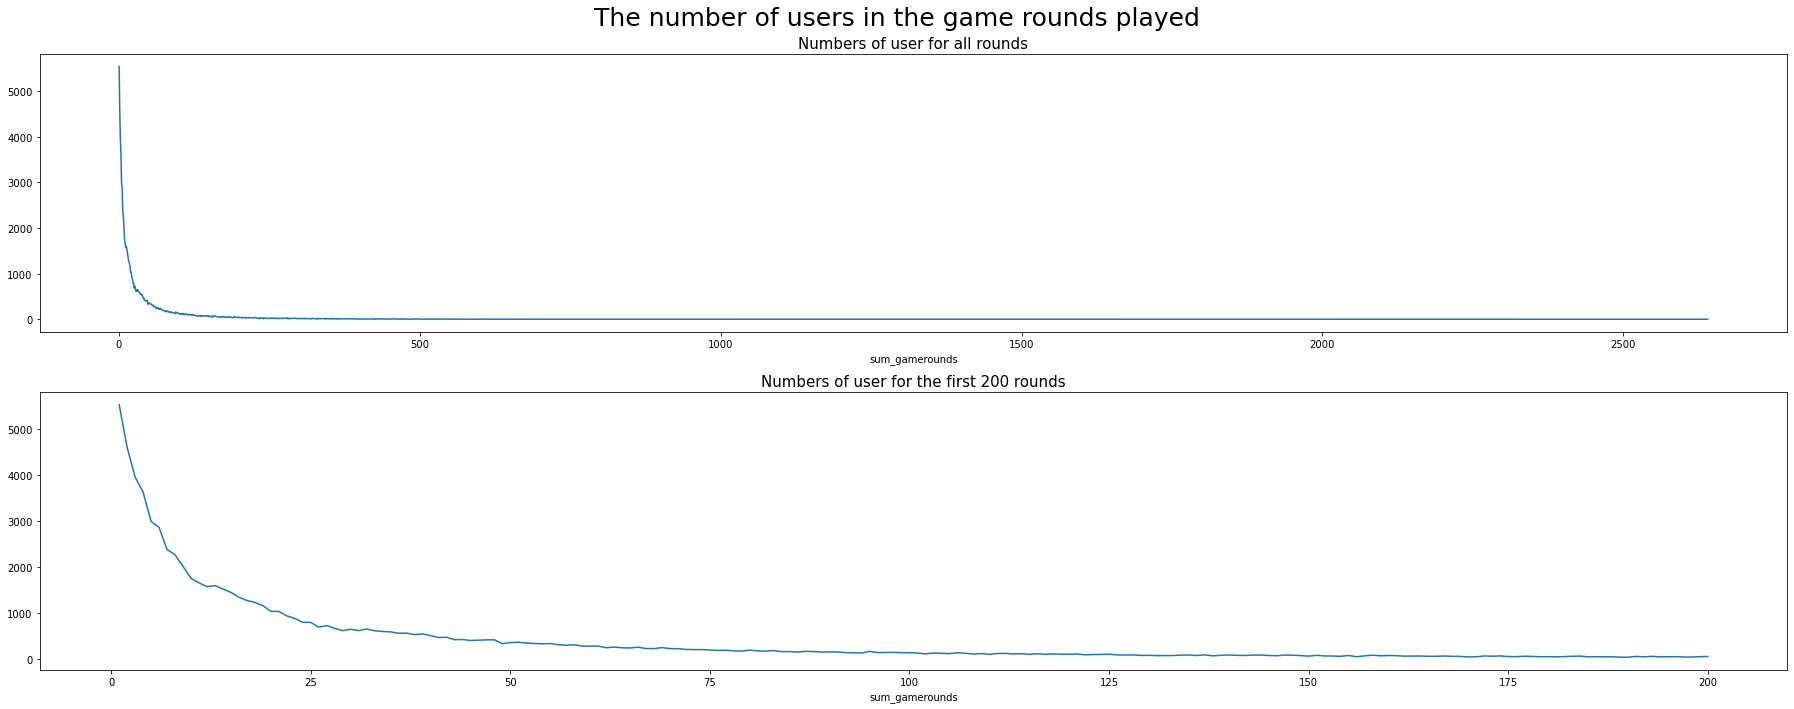

In [16]:
# User retention as levels go up
fig, axes = plt.subplots(2, 1, figsize = (25,10))
df.groupby('sum_gamerounds')['userid'].count().plot(ax = axes[0])
df.groupby('sum_gamerounds')['userid'].count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("Numbers of user for all rounds", fontsize = 15)
axes[1].set_title("Numbers of user for the first 200 rounds", fontsize = 15)
plt.tight_layout(pad=1);
plt.savefig('The number of users in the game rounds played.png')

**We can see that users tend to lose their interest in the game as the game gets harder.**

In [17]:
df.groupby('version').describe()['sum_gamerounds']

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,42761.0000,53.5998,102.7878,1.0000,6.0000,18.0000,53.0000,2438.0000
gate_40,43432.0000,53.7284,105.0930,1.0000,6.0000,18.0000,55.0000,2640.0000


In [18]:
df.groupby('version').describe()['retention_1']

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,42761.0000,0.4675,0.4990,0.0000,0.0000,0.0000,1.0000,1.0000
gate_40,43432.0000,0.4622,0.4986,0.0000,0.0000,0.0000,1.0000,1.0000


In [19]:
df.groupby('version').describe()['retention_7']

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,42761.0000,0.1984,0.3988,0.0000,0.0000,0.0000,0.0000,1.0000
gate_40,43432.0000,0.1903,0.3926,0.0000,0.0000,0.0000,0.0000,1.0000


Looking at the summary statistics of retention variables by version and comparing with sum_gamerounds, there are similarities between groups

# 2. A/B Testing

### Test whether there is a change in terms of sum_gamerounds
H0: There **is no** different between the control and treatment group

H1: There **is** different between the control and treatment group

Based on the visualization of sum_gamerounds separated by version, it does not appear that the data is normally distributed. T-test may not be a good testing method here. We will check the normality of data using the Shapiro-Wilks Normality Test to make sure our assumption is correct.

In [20]:
control = df.query('version == "gate_30"')['sum_gamerounds']

In [21]:
treatment = df.query('version == "gate_40"')['sum_gamerounds']

In [22]:
print('p-value for control-group normality:',shapiro(control)[1])

p-value for control-group normality: 0.0


In [23]:
print('p-value for test-group normality:',shapiro(treatment)[1])

p-value for test-group normality: 0.0


**None of the groups is normally distributed. As a result, instead of using the T-test, we will conduct Mann Whitney U test**

In [24]:
res = mannwhitneyu(control, treatment)[1]
res

0.05953130903983879

With this p-value, we **fail to reject the null hypothesis at 5% significance**. However, we **can reject the significance level at 10% significance**.

## Test whether there is a change in terms of retention

In [25]:
df.groupby('version').describe()[['retention_1','retention_7']]

retention_1                                                   \
              count   mean    std    min    25%    50%    75%    max   
version                                                                
gate_30  42761.0000 0.4675 0.4990 0.0000 0.0000 0.0000 1.0000 1.0000   
gate_40  43432.0000 0.4622 0.4986 0.0000 0.0000 0.0000 1.0000 1.0000   

        retention_7                                                   
              count   mean    std    min    25%    50%    75%    max  
version                                                               
gate_30  42761.0000 0.1984 0.3988 0.0000 0.0000 0.0000 0.0000 1.0000  
gate_40  43432.0000 0.1903 0.3926 0.0000 0.0000 0.0000 0.0000 1.0000

**We can see that there is a difference in terms of the mean value of retention. However, it is not too obvious that we can conclude anything out of that.**

# 3. Conclusion

## General Comment

There is a huge decrease in terms of retention as the difficulty of the game keeps increasing. This could be attributed to several reasons
* When the user reaches around round 150, the difficulty gets massively harder, making it more challenging for users to follow along
* There may be a trade-off between purchases and chance of moving to the next level, which means if the users do not purchase new functions/skins/skills, they will not likely to get through. This may help the producers have more financial benefits, but at the same time decrease users' retention to the game
* There is a novelty effect, which the users appear interested to the game at first, then their interest decreases overtime, which is expected

 **We should work along with the User Experience Research Team to be able to figure out what happens to give out suitable solution**

## A/B Testing Discussion

Recall the Business Problem:

**As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.**

* In terms of difference of users' retention over game round, there is not statistical proof to conclude that changing the first gate from level 30 to level 40 would make any difference. I suggest game developers should run the test on a longer time to see more obvious results. If the test was run on a long enough period, then the result indicates that new feature does not really contribute as much, thus our A/B test is unsuccessful. 

* In terms of retention after 1 day and 7 days, there is also not enough statistical proof to conclude that new feature will keep users stay with the game longer. Both control and treatment group produce the similar mean with similar standard deviation. 

### In short, we have an unsuccessful test case